# Introduction

A short notebook where we explore skin color analysis

## Import libraries

In [1]:
# Basic libraries
import os
import warnings
import cv2
from tqdm import tqdm 
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Approach

We will determine the color of the skin by calculating the Individual Typology Angle (ITA). To calculate the ITA value, we first must:
- Convert the image to the LAB format
    - L represents lightness (from black to white),
    - A represents the green–red axis,
    - B represents the blue–yellow axis
- Create a mask of the lesion, since it will interfere with the measurment. That way we can cacluate ITA only on the skin

After we may apply the following formula

**ITA = arctangent((L - 50) / B) * (180 / pi)**

## Defining functions

In [2]:
def classify_skin_tone(ita_val):
    """Classifies skin tone based on passed ITA value"""
    if ita_val > 55:
        return "Very Light"
    elif ita_val > 41:
        return "Light"
    elif ita_val > 28:
        return "Intermediate"
    elif ita_val > 10:
        return "Tan"
    elif ita_val > -30:
        return "Brown"
    else:
        return "Dark"



In [3]:
def predict_skin_color(image: np.ndarray, mask: np.ndarray) -> str:
    """
    Predicts the skin tone category from an RGB image using a binary mask.

    This function extracts skin pixels from the image using the provided mask,
    converts them to the LAB color space, and computes the Individual Typology
    Angle (ITA) to estimate the skin tone.

    Parameters:
    ----------
    image : np.ndarray
        RGB image of shape (H, W, 3).

    mask : np.ndarray
        Binary mask of shape (H, W). Skin regions should be marked with 0,
        non-skin with 1.
    """
    # Ensure mask has the same size as image
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Re-threshold after resizing to ensure binary values (0 or 1)
    _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

    # Convert whole image to LAB
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Extract LAB values of skin pixels
    skin_lab = image_lab[mask == 0]
    
    # Compute mean LAB values
    mean_L, mean_A, mean_B = np.mean(skin_lab, axis=0)

    # ITA = arctangent((L - 50) / B) * (180 / pi)
    L = skin_lab[:, 0].astype(np.float32)
    B = skin_lab[:, 2].astype(np.float32)
    ita = np.arctan2((L - 50), B) * 180 / np.pi
    
    mean_ita = np.mean(ita)

    skin_tone_category = classify_skin_tone(mean_ita)
    
    return skin_tone_category



In [4]:
def process_image_batch(
    csv_file: str,
    image_dir: str,
    mask_dir: str,
    output_csv: str = "skin_tone_estimates.csv"
) -> None:
    """
    Processes a batch of images and corresponding masks to estimate skin tone categories.

    This function reads a CSV file containing image names, loads each corresponding image
    and segmentation mask, predicts the skin tone category using `predict_skin_color`, and
    saves the results to a new CSV file.
    """
    df = pd.read_csv(csv_file)
    skin_tones = []

    for _, row in df.iterrows():
        base_name = row["image_name"]
        image_path = os.path.join(image_dir, base_name + ".jpg")
        mask_path = os.path.join(mask_dir, base_name + ".png")

        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Failed to load image: {image_path}")
            skin_tones.append(None)
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ Failed to load mask: {mask_path}")
            skin_tones.append(None)
            continue

        try:
            tone = predict_skin_color(image, mask)
        except Exception as e:
            print(f"⚠️ Error processing {base_name}: {e}")
            tone = None

        skin_tones.append(tone)

    df["skin_tone"] = skin_tones
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved updated CSV to {output_csv}")

## Processing and Evaluation

In [5]:
CSV_PATH = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/test_truth.csv"
IMAGE_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/test_output/train/benign/"
MASK_FOLDER = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/segmentation_mask/"
CSV_OUTPUT = "/Users/mipopovic/Desktop/MunjeLumenDS2025/data/skin_tone_estimates.csv"

In [6]:
process_image_batch(CSV_PATH,IMAGE_FOLDER,MASK_FOLDER, CSV_OUTPUT)

✅ Saved updated CSV to /Users/mipopovic/Desktop/MunjeLumenDS2025/data/skin_tone_estimates.csv


## Conclusion

In [7]:
def show_images_with_skin_tone(
    folder_path: str,
    csv_path: str,
    num_images: int = 5,
    image_width: int = 100,
    image_height: int = 100
):
    """Displays images from a folder in a row with their estimated skin tone from a CSV."""
    df = pd.read_csv(csv_path)
    tone_dict = dict(zip(df["image_name"].astype(str) + ".jpg", df["skin_tone"]))

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:num_images]

    if not image_files:
        print("No images found.")
        return

    fig, axes = plt.subplots(1, len(image_files), figsize=(len(image_files) * 3, 4))

    # Handle single image case
    if len(image_files) == 1:
        axes = [axes]

    for ax, filename in zip(axes, image_files):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            ax.axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (image_width, image_height))

        skin_tone = tone_dict.get(filename, "Unknown")

        ax.imshow(img)
        ax.set_title(filename, fontsize=9)
        ax.set_xlabel(f"Tone: {skin_tone}", fontsize=9)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout()
    plt.show()


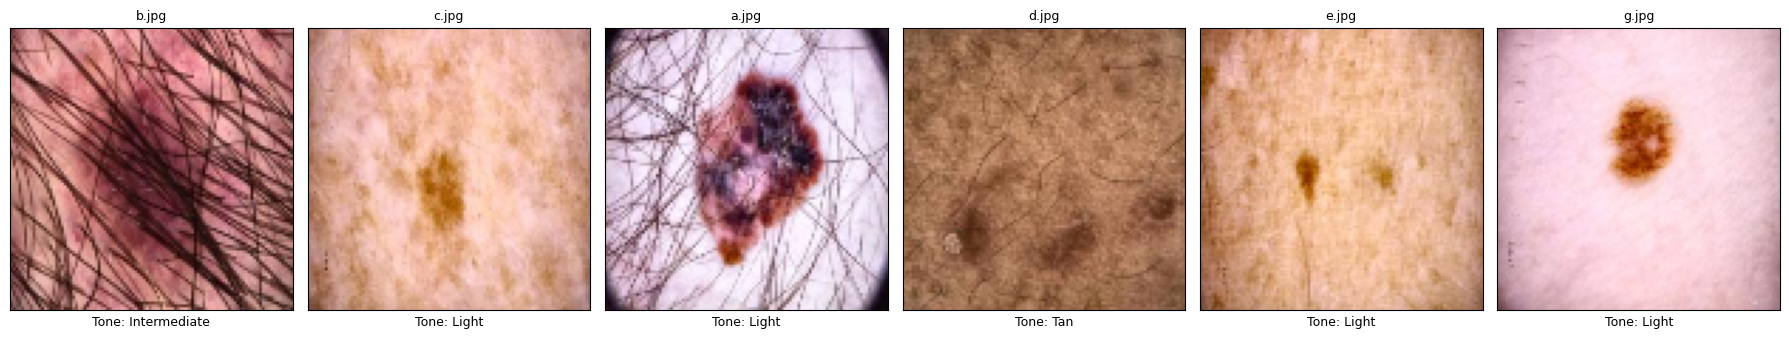

In [8]:
show_images_with_skin_tone(
    folder_path=IMAGE_FOLDER,
    csv_path=CSV_OUTPUT,
    num_images=6
)